In [1]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    #spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    #extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [3]:
# Paths to the .mhd files
filenameFlair = "./BRATS2015_Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.mha"
filenameT1 = "./BRATS2015_Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_T1.54513/VSD.Brain.XX.O.MR_T1.54513.mha"
filenameT1c = "./BRATS2015_Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_T1c.54514/VSD.Brain.XX.O.MR_T1c.54514.mha"
filenameT2 = "./BRATS2015_Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_T2.54515/VSD.Brain.XX.O.MR_T2.54515.mha"
filenameOT = "./BRATS2015_Training/HGG/brats_2013_pat0001_1/VSD.Brain_3more.XX.O.OT.54517/VSD.Brain_3more.XX.O.OT.54517.mha"

# Slice index to visualize with 'sitk_show'
idxSlice = 69

# int label to assign to the segmented gray matter
labelGrayMatter = 1

In [4]:
imgFlairOriginal = SimpleITK.ReadImage(filenameFlair)
imgT1Original = SimpleITK.ReadImage(filenameT1)
imgT1cOriginal = SimpleITK.ReadImage(filenameT1c)
imgT2Original = SimpleITK.ReadImage(filenameT2)
imgOTOriginal = SimpleITK.ReadImage(filenameOT)

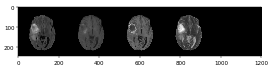

In [5]:
sitk_show(SimpleITK.Tile(imgFlairOriginal[:, :, idxSlice],
                         imgT1Original[:, :, idxSlice],
                         imgT1cOriginal[:, :, idxSlice],
                         imgT2Original[:, :, idxSlice],
                         imgOTOriginal[:, :, idxSlice],
                         (5, 4, 3, 2, 1)))

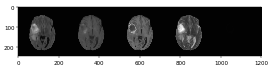

In [6]:
imgFlairSmooth = SimpleITK.CurvatureFlow(image1=imgFlairOriginal,
                                      timeStep=0.125,
                                      numberOfIterations=5)
imgT1Smooth = SimpleITK.CurvatureFlow(image1=imgT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)
imgT1cSmooth = SimpleITK.CurvatureFlow(image1=imgT1cOriginal,
                                      timeStep=0.125,
                                      numberOfIterations=5)
imgT2Smooth = SimpleITK.CurvatureFlow(image1=imgT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)
imgOTSmooth = SimpleITK.CurvatureFlow(image1=imgOTOriginal,
                                      timeStep=0.125,
                                      numberOfIterations=5)

sitk_show(SimpleITK.Tile(imgFlairSmooth[:, :, idxSlice],
                         imgT1Smooth[:, :, idxSlice],
                         imgT1cSmooth[:, :, idxSlice],
                         imgT2Smooth[:, :, idxSlice],
                         imgOTSmooth[:, :, idxSlice],
                         (5, 4, 3, 2, 1)))

In [7]:
lstSeeds = [(165, 178, idxSlice),
            (98, 165, idxSlice),
            (205, 125, idxSlice),
            (173, 205, idxSlice)]

In [8]:
def sitk_tile_vec(lstImgs):
    lstImgToCompose = []
    for idxComp in range(lstImgs[0].GetNumberOfComponentsPerPixel()):
        lstImgToTile = []
        for img in lstImgs:
            lstImgToTile.append(SimpleITK.VectorIndexSelectionCast(img, idxComp))
        lstImgToCompose.append(SimpleITK.Tile(lstImgToTile, (len(lstImgs), 1, 0)))
    sitk_show(SimpleITK.Compose(lstImgToCompose))

In [9]:
imgGrayMatterFlair = SimpleITK.ConfidenceConnected(image1=imgFlairSmooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.0,
                                                replaceValue=labelGrayMatter)

imgGrayMatterT1 = SimpleITK.ConfidenceConnected(image1=imgT1Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.0,
                                                replaceValue=labelGrayMatter)

imgGrayMatterT1c = SimpleITK.ConfidenceConnected(image1=imgT1cSmooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.0,
                                                replaceValue=labelGrayMatter)

imgGrayMatterT2 = SimpleITK.ConfidenceConnected(image1=imgT2Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.5,
                                                replaceValue=labelGrayMatter)

imgGrayMatterOT = SimpleITK.ConfidenceConnected(image1=imgOTSmooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.0,
                                                replaceValue=labelGrayMatter)

imgFLairSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgFlairSmooth), 
                                imgGrayMatterFlair.GetPixelID())
imgT1SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT1Smooth), 
                                imgGrayMatterT1.GetPixelID())
imgT1cSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT1cSmooth), 
                                imgGrayMatterT1c.GetPixelID())
imgT2SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT2Smooth), 
                                imgGrayMatterT2.GetPixelID())
imgOTSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgOTSmooth), 
                                imgGrayMatterOT.GetPixelID())

sitk_tile_vec([SimpleITK.LabelOverlay(imgFlairSmoothInt[:,:,idxSlice], 
                                      imgGrayMatterFlair[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgT1SmoothInt[:,:,idxSlice], 
                                      imgGrayMatterT1[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgT1cSmoothInt[:,:,idxSlice], 
                                      imgGrayMatterT1c[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                      imgGrayMatterT2[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgOTSmoothInt[:,:,idxSlice], 
                                      imgGrayMatterOT[:,:,idxSlice])])

NameError: name 'imgFlairSmoothInt' is not defined

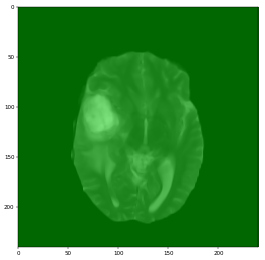

In [10]:
imgComp = SimpleITK.Compose(imgFlairSmooth, 
                            imgT1Smooth, 
                            imgT1cSmooth, 
                            imgT2Smooth, 
                            imgOTSmooth)

imgGrayMatterComp = SimpleITK.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=1,
                                               multiplier=0.1,
                                               replaceValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                 imgGrayMatterComp[:,:,idxSlice]))

In [11]:
SimpleITK.WriteImage(imgGrayMatterComp, "GrayMatter.mhd")